In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

## Load Data

Load all the classes into different Dataframes

In [3]:
class1 = pd.read_csv('data/Data_Class_1.csv')
class3 = pd.read_csv('data/Data_Class_3.csv')
class6 = pd.read_csv('data/Data_Class_6.csv')

## Descriptive Statistics

Combine all classes into one dataset and view the top rows

In [4]:
data = pd.concat([class1, class3, class6], ignore_index=True)
data

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type,Wilderness_Area,Vegetation_Type
0,41,2699,347,3,0,0,2096,213,234,159,6853,37.32,282.46,125.22,6.23,Type_20,Area_1,Type_1
1,52,2739,323,25,85,43,3118,149,205,192,6219,76.51,182.57,532.19,30.65,Type_29,Area_1,Type_1
2,53,2696,72,2,30,0,3271,222,234,149,6071,86.37,374.79,275.52,59.96,Type_30,Area_1,Type_1
3,56,2722,315,24,30,19,3216,148,212,200,6132,85.31,364.30,1182.48,22.21,Type_16,Area_1,Type_1
4,68,2919,13,13,90,6,5321,207,214,142,4060,78.13,303.26,1198.69,14.22,Type_29,Area_1,Type_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5935,15106,2480,10,21,150,38,607,193,194,133,1436,82.97,247.13,190.52,45.88,Type_10,Area_3,Type_6
5936,15110,2600,57,19,0,0,731,229,197,93,1332,38.82,163.93,853.03,34.03,Type_10,Area_3,Type_6
5937,15111,2508,33,26,67,1,644,204,173,91,1385,75.93,366.25,442.88,6.98,Type_10,Area_3,Type_6
5938,15112,2610,59,17,60,10,674,231,202,98,1328,74.65,312.00,651.50,55.74,Type_10,Area_3,Type_6


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5940 entries, 0 to 5939
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Id                                  5940 non-null   int64  
 1   Altitude                            5940 non-null   int64  
 2   Slope_Orientation                   5940 non-null   int64  
 3   Slope                               5940 non-null   int64  
 4   Horizontal_Distance_To_Water        5940 non-null   int64  
 5   Vertical_Distance_To_Water          5940 non-null   int64  
 6   Horizontal_Distance_To_Roadways     5940 non-null   int64  
 7   Shadow_Index_9h                     5940 non-null   int64  
 8   Shadow_Index_12h                    5940 non-null   int64  
 9   Shadow_Index_15h                    5940 non-null   int64  
 10  Horizontal_Distance_To_Fire_Points  5940 non-null   int64  
 11  Canopy_Density                      5940 no

According to this information:
- 5940 rows
- 18 columns
- No null values
- 3 categorical columns and 15 numerical columns

#### Numerical Columns

View some metrics of each numerical column

In [6]:
data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000


#### Categorical columns

View some metrics of each categorical column

In [7]:
data.describe(include='object')

,Soil_Type,Wilderness_Area,Vegetation_Type
count,5940,5940,5940
unique,32,4,3
top,Type_10,Area_3,Type_1
freq,1634,2529,2160


## Univariate Analysis

In [8]:
numerical_columns = data.select_dtypes(exclude='object').columns.drop('Id')
categorical_columns = data.select_dtypes(include='object').columns

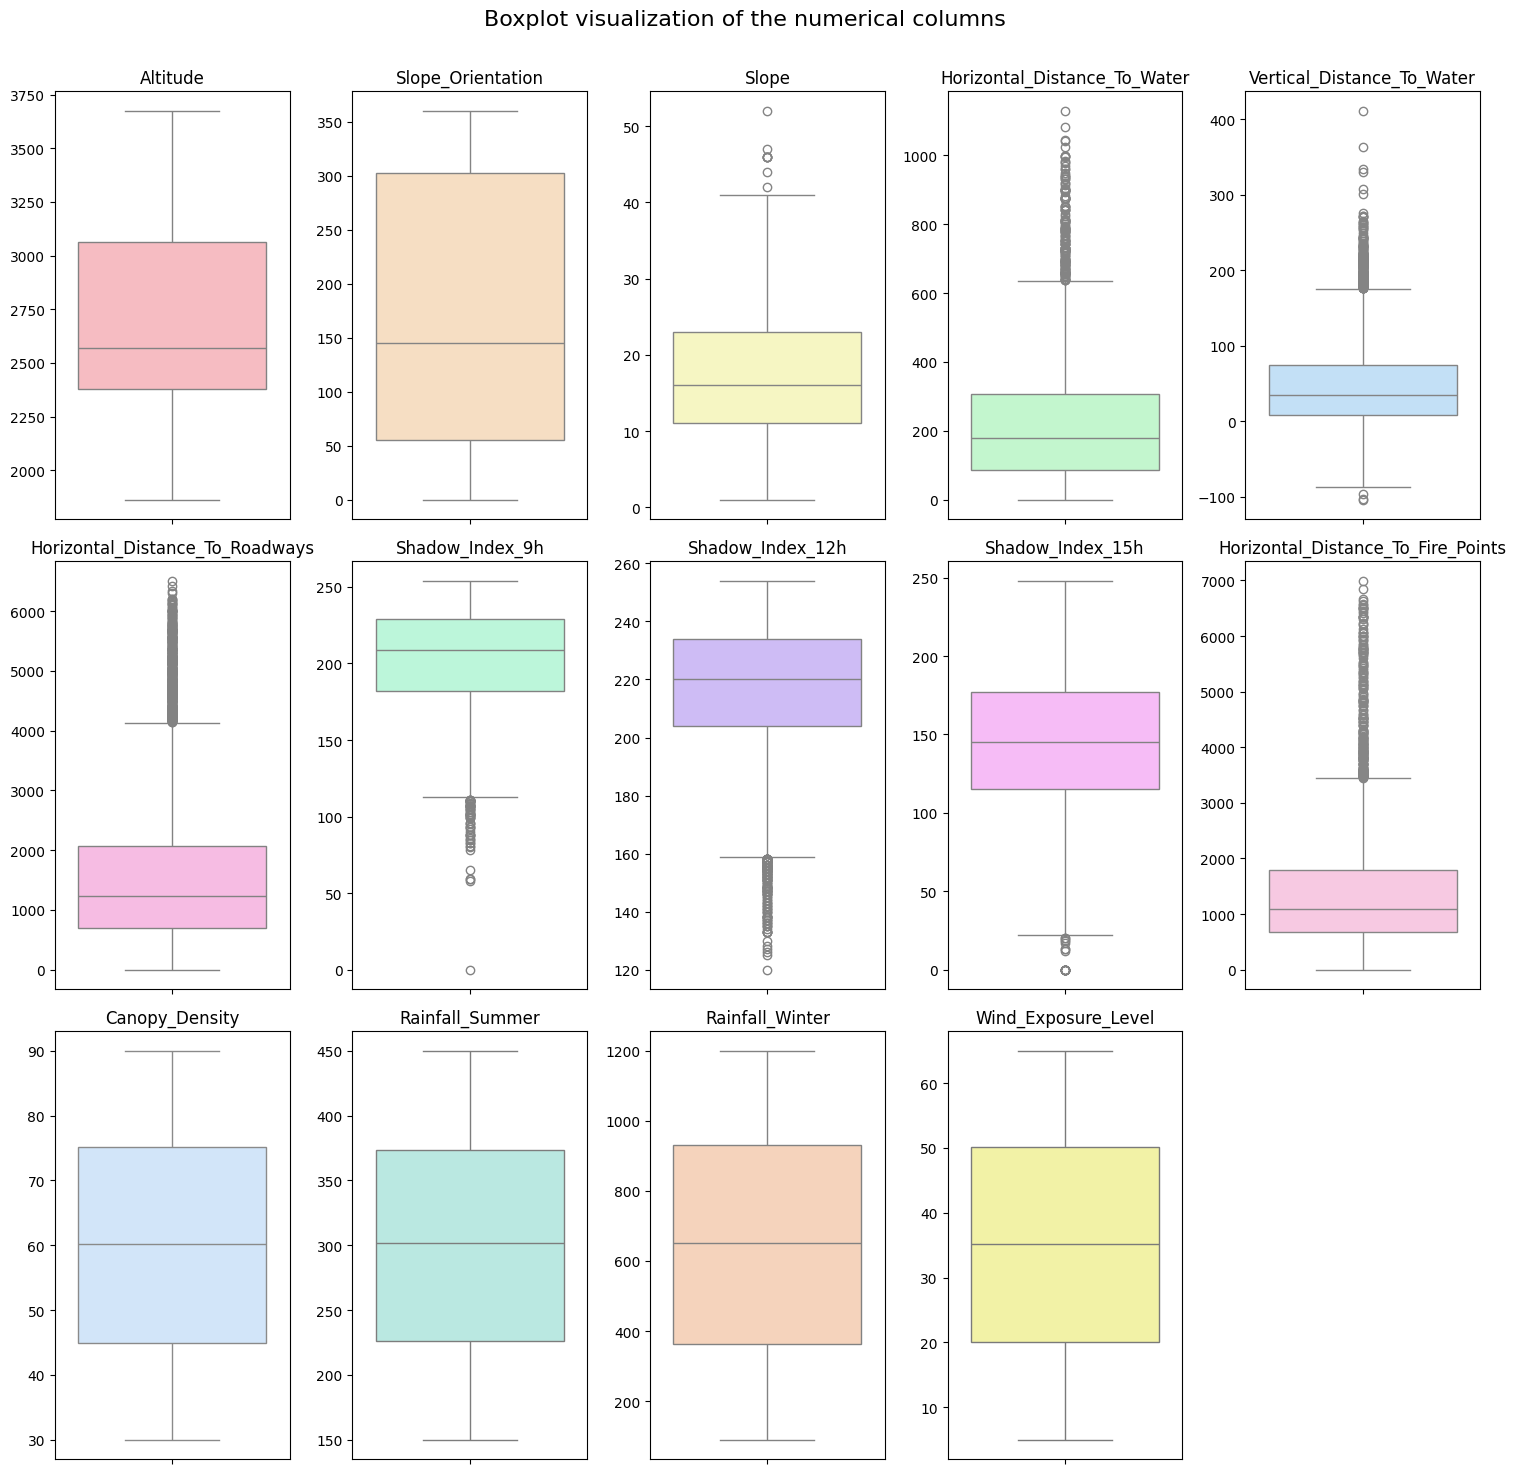

In [9]:
boxplot_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns')

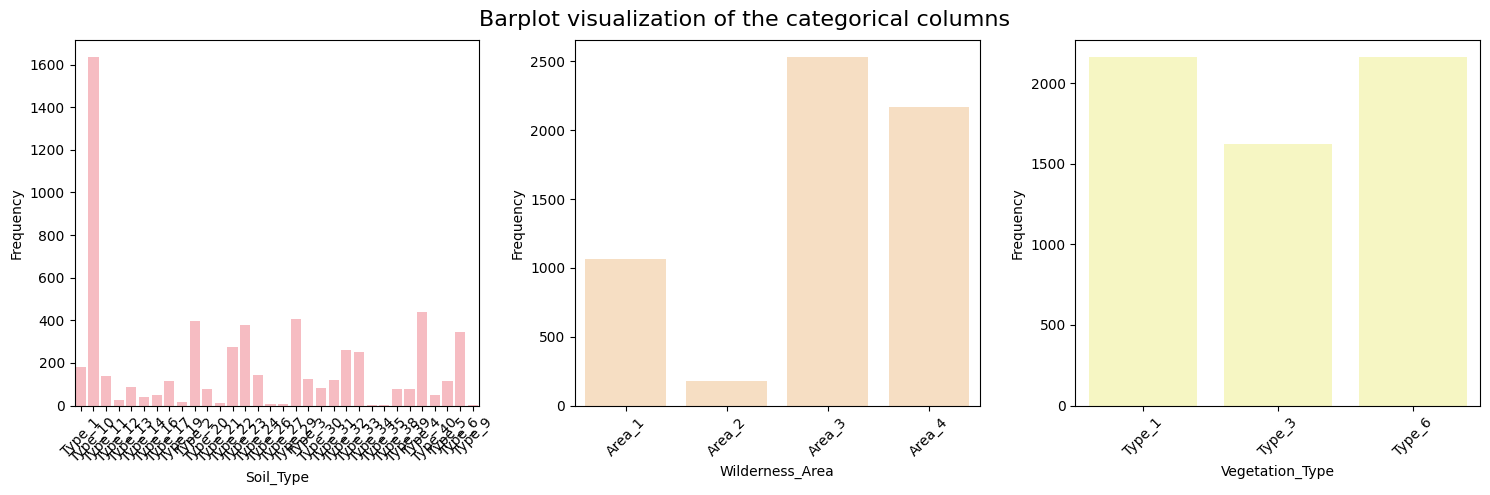

In [10]:
barplot_visualization(data, categorical_columns, 'Barplot visualization of the categorical columns')

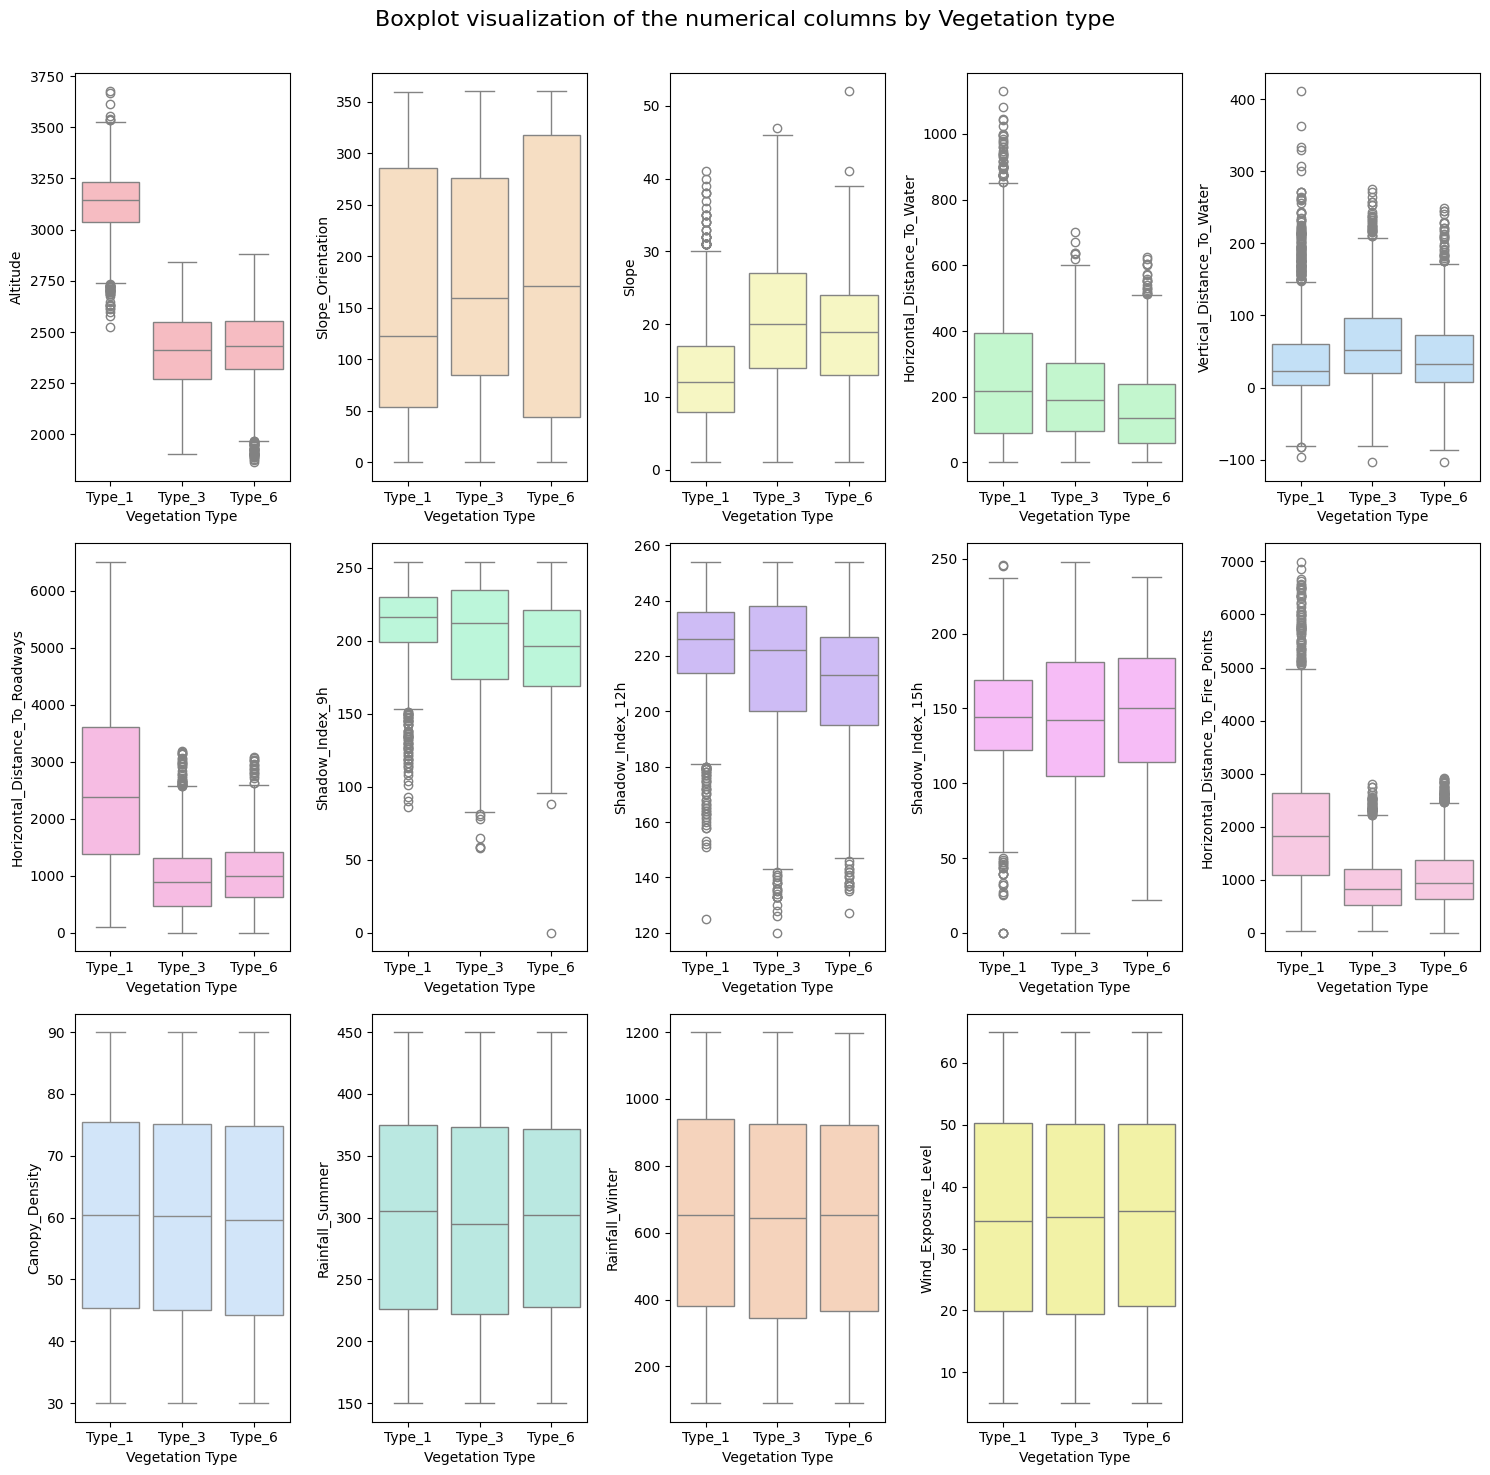

In [11]:
boxplot_by_type_visualization(data, numerical_columns, 'Boxplot visualization of the numerical columns by Vegetation type')

## Bivariate Analysis

In [12]:
encoded_data = data.copy()
encoded_data['Soil_Type_Enc'] = pd.factorize(data['Soil_Type'])[0]
encoded_data['Wilderness_Area_Enc'] = pd.factorize(data['Wilderness_Area'])[0]
encoded_data['Vegetation_Type_Enc'] = pd.factorize(data['Vegetation_Type'])[0]

In [13]:
encoded_data.describe()

,Id,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Canopy_Density,Rainfall_Summer,Rainfall_Winter,Wind_Exposure_Level,Soil_Type_Enc,Wilderness_Area_Enc,Vegetation_Type_Enc
count,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000,5940.000000
mean,8038.627946,2672.851684,171.001347,17.276263,214.397475,48.701347,1588.265488,202.461448,216.604882,144.623232,1360.505387,60.077453,300.091620,647.547544,35.107199,15.752862,1.581650,1.000000
std,4201.653201,387.964294,121.193059,8.397512,176.610733,54.068275,1265.901292,33.925223,23.720654,44.343675,998.115844,17.404128,86.575054,323.281830,17.442532,8.008764,1.153733,0.852875
min,41.000000,1863.000000,0.000000,1.000000,0.000000,-104.000000,0.000000,0.000000,120.000000,0.000000,0.000000,30.000000,150.030000,90.070000,5.000000,0.000000,0.000000,0.000000
25%,4926.250000,2378.000000,55.000000,11.000000,85.000000,8.000000,695.250000,182.000000,204.000000,115.000000,674.000000,44.910000,225.855000,363.685000,20.010000,10.000000,1.000000,0.000000
50%,8070.000000,2572.000000,145.000000,16.000000,180.000000,34.000000,1230.000000,209.000000,220.000000,145.000000,1095.000000,60.190000,301.910000,650.650000,35.215000,18.000000,1.000000,1.000000
75%,11311.250000,3062.000000,302.000000,23.000000,306.000000,75.000000,2072.000000,229.000000,234.000000,177.250000,1785.000000,75.147500,373.827500,930.800000,50.205000,18.000000,3.000000,2.000000
max,15118.000000,3675.000000,360.000000,52.000000,1129.000000,411.000000,6508.000000,254.000000,254.000000,248.000000,6993.000000,89.990000,449.970000,1199.880000,64.990000,31.000000,3.000000,2.000000


<Axes: >

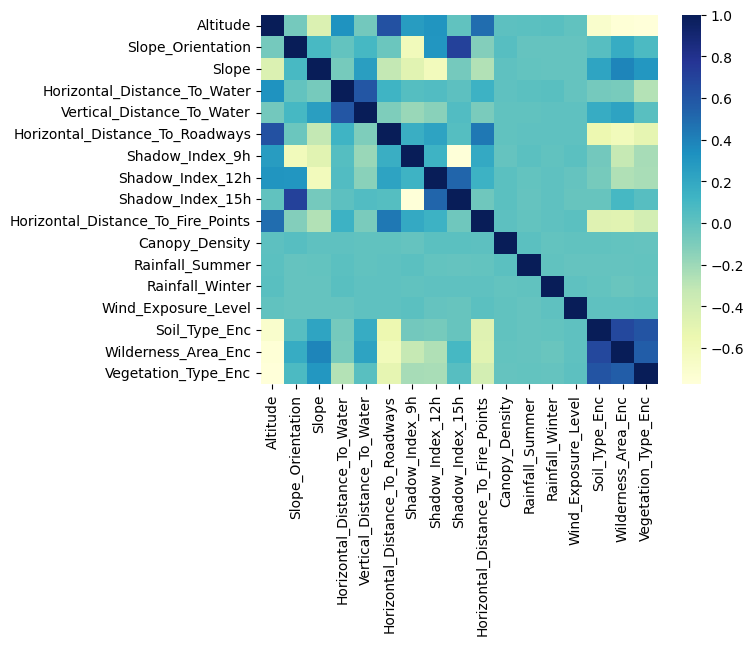

In [14]:
# Remove Id for correlation matrix
encoded_data_without_id = encoded_data.drop('Id', axis=1)

sns.heatmap(encoded_data_without_id.corr(numeric_only=True), cmap="YlGnBu")

In the next step, the columns with close to 0 correlation with any other columns will be deleted, seeing as these do not provide any benefit to our analysis.

The following columns will be removed:
- Canopy_Density
- Rainfall_Summer
- Rainfall_Winter
- Wind_Exposure_Level

In [15]:
# Removing the columns without any correlation
encoded_data_without_id = encoded_data_without_id.drop(['Canopy_Density', 'Rainfall_Summer', 'Rainfall_Winter', 'Wind_Exposure_Level'], axis=1)

<Axes: >

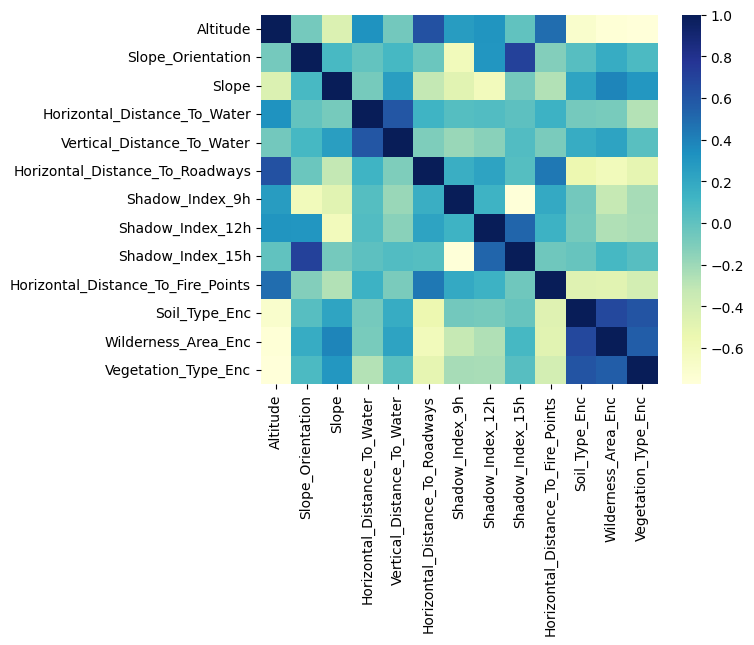

In [16]:
corr_matrix = encoded_data_without_id.corr(numeric_only=True)

sns.heatmap(corr_matrix, cmap="YlGnBu")

In [17]:
corr_matrix

,Altitude,Slope_Orientation,Slope,Horizontal_Distance_To_Water,Vertical_Distance_To_Water,Horizontal_Distance_To_Roadways,Shadow_Index_9h,Shadow_Index_12h,Shadow_Index_15h,Horizontal_Distance_To_Fire_Points,Soil_Type_Enc,Wilderness_Area_Enc,Vegetation_Type_Enc
Altitude,1.000000,-0.073906,-0.445400,0.320920,-0.061765,0.620801,0.268285,0.309296,0.000590,0.493605,-0.699724,-0.759792,-0.774637
Slope_Orientation,-0.073906,1.000000,0.091453,-0.006280,0.093974,-0.037092,-0.605879,0.301922,0.704323,-0.117486,0.035943,0.173883,0.074433
Slope,-0.445400,0.091453,1.000000,-0.081415,0.255881,-0.322957,-0.480340,-0.612619,-0.073909,-0.263317,0.222414,0.387427,0.298247
Horizontal_Distance_To_Water,0.320920,-0.006280,-0.081415,1.000000,0.595274,0.120164,0.037495,0.055733,0.011886,0.135802,-0.068218,-0.083824,-0.269011
Vertical_Distance_To_Water,-0.061765,0.093974,0.255881,0.595274,1.000000,-0.105307,-0.189484,-0.138105,0.053614,-0.095020,0.168866,0.224435,0.028331
Horizontal_Distance_To_Roadways,0.620801,-0.037092,-0.322957,0.120164,-0.105307,1.000000,0.154439,0.227023,0.036593,0.444786,-0.546106,-0.605209,-0.510261
Shadow_Index_9h,0.268285,-0.605879,-0.480340,0.037495,-0.189484,0.154439,1.000000,0.129316,-0.762588,0.189466,-0.065123,-0.326906,-0.227859
Shadow_Index_12h,0.309296,0.301922,-0.612619,0.055733,-0.138105,0.227023,0.129316,1.000000,0.525597,0.133809,-0.078419,-0.257865,-0.238884
Shadow_Index_15h,0.000590,0.704323,-0.073909,0.011886,0.053614,0.036593,-0.762588,0.525597,1.000000,-0.053656,-0.024120,0.095153,0.034780
Horizontal_Distance_To_Fire_Points,0.493605,-0.117486,-0.263317,0.135802,-0.095020,0.444786,0.189466,0.133809,-0.053656,1.000000,-0.466654,-0.483002,-0.400223


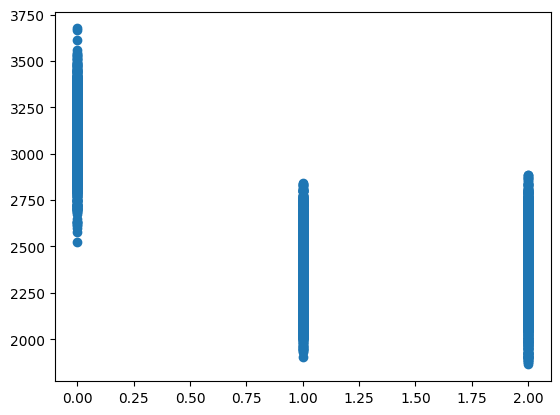

In [18]:
plt.scatter(y=encoded_data['Altitude'], x=encoded_data['Vegetation_Type_Enc'])

<Axes: xlabel='Soil_Type'>

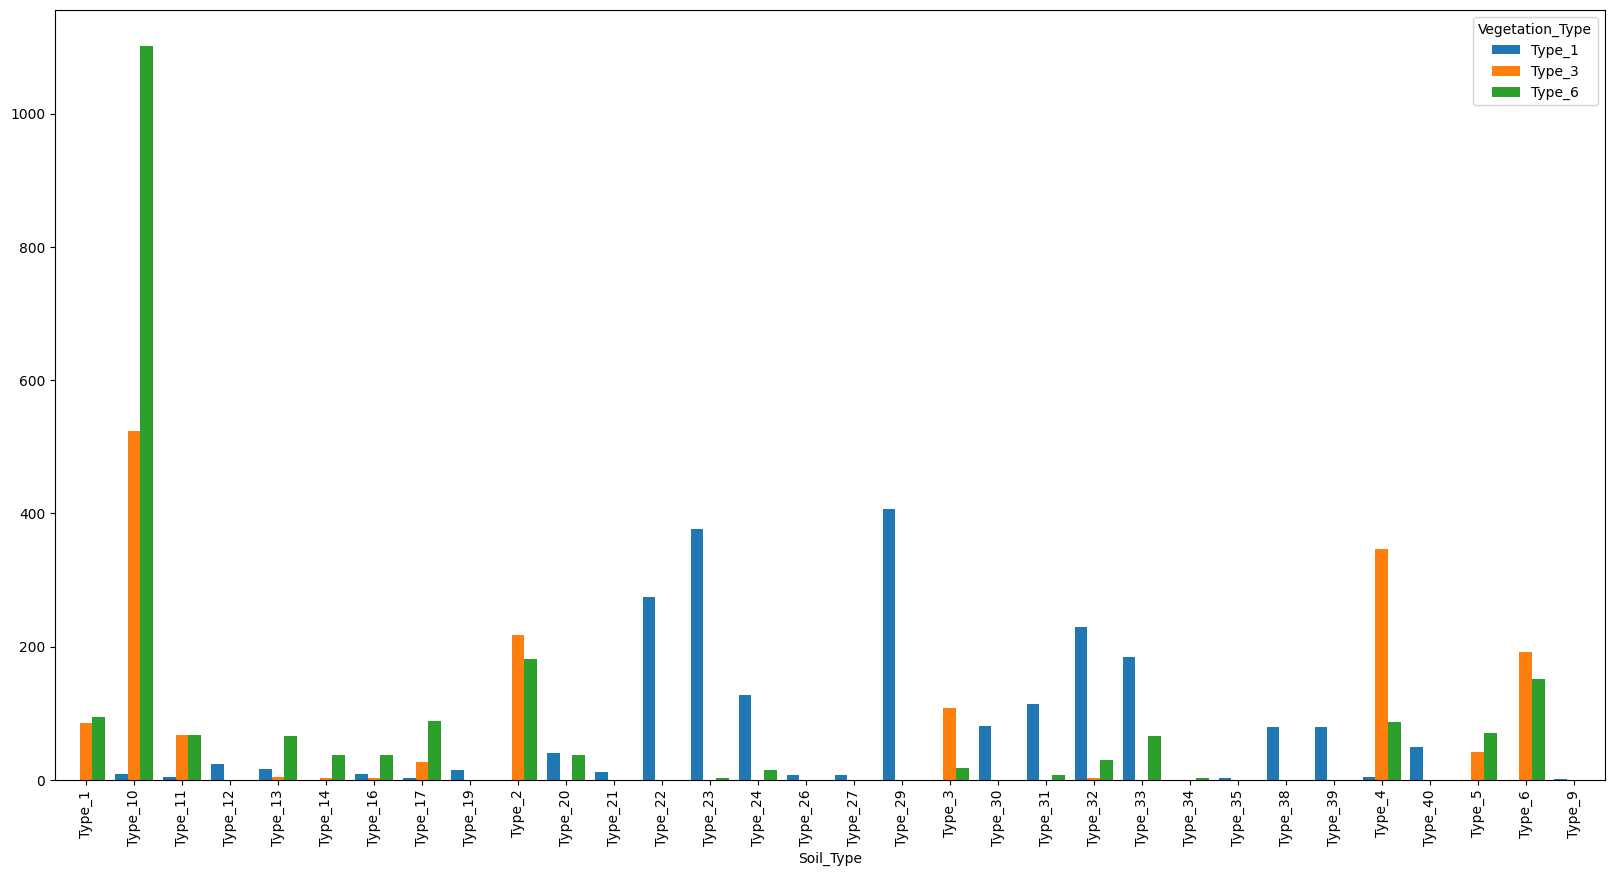

In [19]:
pd.crosstab(data['Soil_Type'], data['Vegetation_Type']).plot(kind='bar', figsize=(20, 10), width=0.8)

<Axes: xlabel='Wilderness_Area'>

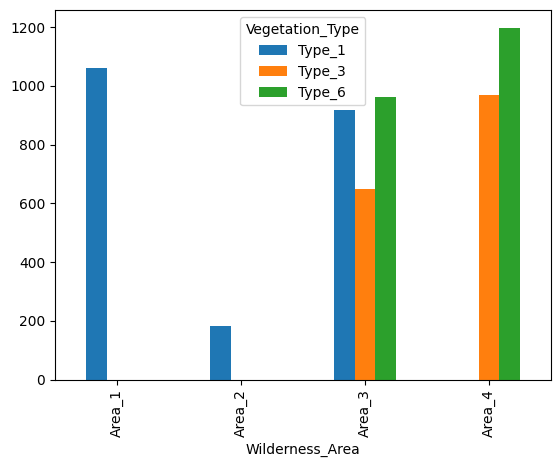

In [20]:
pd.crosstab(data['Wilderness_Area'], data['Vegetation_Type']).plot(kind='bar')